In [1]:
from IPython.display import display,HTML
def dhtml(str):
    display(HTML("""<style>
    @import 'https://fonts.googleapis.com/css?family=Iceberg&effect=3d';      
    </style><h1 class='font-effect-3d' 
    style='font-family:Iceberg; color:#ff1155; font-size:35px;'>
    %s</h1>"""%str))

In [2]:
dhtml('Code Modules, Functions, & Classes')

In [3]:
import numpy as np,pandas as pd,pylab as pl
import h5py,torch,time,copy,urllib,zipfile
from torchvision import transforms,utils,models
from torchsummary import summary as tsummary
from torch.utils.data import DataLoader as tdl
from torch.utils.data import Dataset as tds
import torch.nn.functional as tnnf
import torch.nn as tnn
import tensorflow.image as timage
from IPython.core.magic import register_line_magic
dev=torch.device("cuda:0" \
if torch.cuda.is_available() else "cpu")

In [4]:
class TData(tds):
    def __init__(self,x,y):   
        self.x=torch.tensor(x,dtype=torch.float32)
        self.y=torch.tensor(y,dtype=torch.int32)
    def __getitem__(self,index):
        img,lbl=self.x[index],self.y[index]
        return img,lbl
    def __len__(self):
        return self.y.shape[0]

In [5]:
@register_line_magic
def display_examples(data):
    for images,labels in dataloaders[data]:  
        print('Image dimensions: %s'%str(images.shape))
        print('Label dimensions: %s'%str(labels.shape))
        n=np.random.randint(1,50)
        fig=pl.figure(figsize=(10,4))
        for i in range(n,n+5):
            ax=fig.add_subplot(1,5,i-n+1,\
            xticks=[],yticks=[],title=labels[i].item())
            ax.imshow((images[i]).reshape(img_size,img_size,3))
        break

In [6]:
dhtml('Data')

In [7]:
img_size=64
fpath='https://olgabelitskaya.github.io/'
zf='LetterColorImages_123.h5.zip'
input_file=urllib.request.urlopen(fpath+zf)
output_file=open(zf,'wb'); 
output_file.write(input_file.read())
output_file.close(); input_file.close()
zipf=zipfile.ZipFile(zf,'r')
zipf.extractall(''); zipf.close()
f=h5py.File(zf[:-4],'r')
keys=list(f.keys()); print(keys)
x=np.array(f[keys[1]],dtype='float32')
x=timage.resize(x,[img_size,img_size])
x=x.numpy().reshape(-1,3,img_size,img_size)
x=x/255
print(x.mean(),x.std())
y=np.array(f[keys[2]],dtype='int32')-1
N=len(y); n=int(.1*N)
shuffle_ids=np.arange(N)
np.random.RandomState(23).shuffle(shuffle_ids)
x,y=x[shuffle_ids][:110*128],y[shuffle_ids][:110*128]

['backgrounds', 'images', 'labels']
0.5900506 0.13820575


In [8]:
random_seed=23; batch_size=128
train=TData(x,y)
dataloaders={'train':tdl(dataset=train,shuffle=True, 
                         batch_size=batch_size)}

Image dimensions: torch.Size([128, 3, 64, 64])
Label dimensions: torch.Size([128])


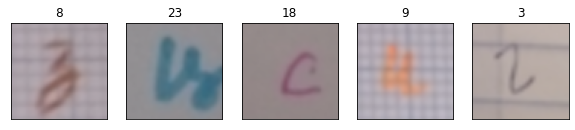

In [9]:
%display_examples train

In [10]:
dhtml('DCGAN')

In [11]:
def weights_init(module):
    classname=module.__class__.__name__
    if classname.find('Conv')!=-1:
        tnn.init.normal_(module.weight.data,0.,.02)
    elif classname.find('BatchNorm')!=-1:
        tnn.init.normal_(module.weight.data,1.,.02)
        tnn.init.constant_(module.bias.data,0)
def convt(x,y,k,s,p):
    return tnn.Sequential(
        tnn.ConvTranspose2d(
            x,y,kernel_size=k,stride=s,\
            padding=p,bias=False),\
        tnn.BatchNorm2d(y),
        tnn.ReLU(True))
def conv(x,y,k,s,p):
    return tnn.Sequential(
        tnn.Conv2d(x,y,kernel_size=k,
                   stride=s,padding=p,
                   bias=False),
        tnn.BatchNorm2d(y),
        tnn.LeakyReLU(.2,inplace=True))

In [16]:
class DCGAN(tnn.Module):
    def __init__(self):
        super(DCGAN,self).__init__()
        self.generator=tnn.Sequential(
            convt(latent_dim,gmaps_num*8,4,1,0),
            convt(gmaps_num*8,gmaps_num*4,4,2,1),
            convt(gmaps_num*4,gmaps_num*2,4,2,1),
            convt(gmaps_num*2,gmaps_num,4,2,1),
            tnn.ConvTranspose2d(
                gmaps_num,3,
                kernel_size=4,stride=2,
                padding=1,bias=False),
            tnn.Tanh())        
        self.discriminator=tnn.Sequential(
            tnn.Conv2d(3,dmaps_num,kernel_size=4,
                       stride=2,padding=1),
            tnn.LeakyReLU(.2,inplace=True),
            conv(dmaps_num,dmaps_num*2,4,2,1),           
            conv(dmaps_num*2,dmaps_num*4,4,2,1),
            conv(dmaps_num*4,dmaps_num*8,4,2,1),
            tnn.Conv2d(
                dmaps_num*8,1,kernel_size=4,
                stride=1,padding=0),
            tnn.Sigmoid())          
    def generator_forward(self,z):
        img=self.generator(z)
        return img 
    def discriminator_forward(self,img):
        pred=model.discriminator(img)
        return pred

In [17]:
random_seed=(123); latent_dim=100
gmaps_num=64; dmaps_num=64
glearning_rate=.0002
dlearning_rate=.0001
grid_num=64
torch.manual_seed(random_seed)
loss_function=tnn.BCELoss()
real_label=1; fake_label=0
fixed_noise=torch\
.randn(grid_num,latent_dim,1,1,device=dev)
model=DCGAN(); model=model.to(dev)
model.apply(weights_init)
print(model)
goptim=torch.optim.Adam(
    model.generator.parameters(),
    betas=(.5,.999),lr=glearning_rate)
doptim=torch.optim.Adam(
    model.discriminator.parameters(),
    betas=(.5,.999),lr=dlearning_rate)

DCGAN(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=

In [18]:
epochs=100
dcosts,gcosts=[],[]
images_from_noise=[]
info='Epoch: %03d/%03d | Batch: %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
for epoch in range(epochs):
    model=model.train()
    for batch_ids,(features,targets) in enumerate(dataloaders['train']):
        doptim.zero_grad()      
        real_images=features.to(dev)
        num_real=real_images.size(0)
        real_label_vec=torch.full((num_real,),real_label,device=dev)
        discr_pred_real=model.discriminator_forward(real_images).view(-1)
        real_loss=loss_function(discr_pred_real,real_label_vec)

        random_vec=torch.randn(batch_size,latent_dim,1,1,device=dev)
        fake_images=model.generator_forward(random_vec)
        fake_label_vec=torch.full((num_real,),fake_label,device=dev)
        discr_pred_fake=model.discriminator_forward(fake_images.detach()).view(-1)
        fake_loss=loss_function(discr_pred_fake,fake_label_vec)
        discr_loss=.5*(real_loss+fake_loss)
        discr_loss.backward()
        doptim.step()        

        goptim.zero_grad()                
        discr_pred_fake=model.discriminator_forward(fake_images).view(-1)
        gener_loss=loss_function(discr_pred_fake,real_label_vec)
        gener_loss.backward()
        goptim.step()

        dcosts.append(discr_loss.item())
        gcosts.append(gener_loss.item())
        if not batch_ids%30:
            print(info%(epoch+1,epochs,batch_ids,
                        len(dataloaders['train']),gener_loss,discr_loss))
    with torch.no_grad():
        fake_images=model.generator_forward(fixed_noise).detach().cpu()
        images_from_noise.append(
            utils.make_grid(fake_images,padding=2,normalize=True))

Epoch: 001/100 | Batch: 000/110 | Gen/Dis Loss: 1.2223/0.7988
Epoch: 001/100 | Batch: 030/110 | Gen/Dis Loss: 8.4152/0.0415
Epoch: 001/100 | Batch: 060/110 | Gen/Dis Loss: 5.9440/0.0706
Epoch: 001/100 | Batch: 090/110 | Gen/Dis Loss: 2.6862/0.1947
Epoch: 002/100 | Batch: 000/110 | Gen/Dis Loss: 4.2048/0.3701
Epoch: 002/100 | Batch: 030/110 | Gen/Dis Loss: 1.7997/0.4655
Epoch: 002/100 | Batch: 060/110 | Gen/Dis Loss: 1.9018/0.5134
Epoch: 002/100 | Batch: 090/110 | Gen/Dis Loss: 2.3531/0.5757
Epoch: 003/100 | Batch: 000/110 | Gen/Dis Loss: 1.2528/0.4660
Epoch: 003/100 | Batch: 030/110 | Gen/Dis Loss: 1.2953/0.3425
Epoch: 003/100 | Batch: 060/110 | Gen/Dis Loss: 1.9678/0.3978
Epoch: 003/100 | Batch: 090/110 | Gen/Dis Loss: 0.7141/0.7515
Epoch: 004/100 | Batch: 000/110 | Gen/Dis Loss: 1.2360/0.3279
Epoch: 004/100 | Batch: 030/110 | Gen/Dis Loss: 0.8611/0.7670
Epoch: 004/100 | Batch: 060/110 | Gen/Dis Loss: 1.0731/0.4201
Epoch: 004/100 | Batch: 090/110 | Gen/Dis Loss: 1.0741/0.4458
Epoch: 0

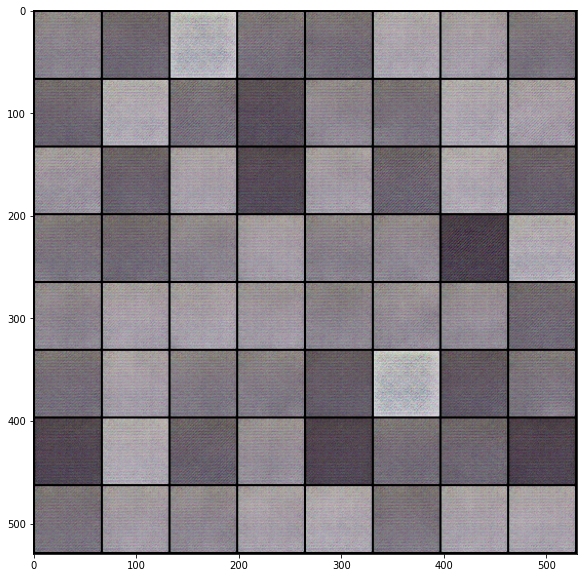

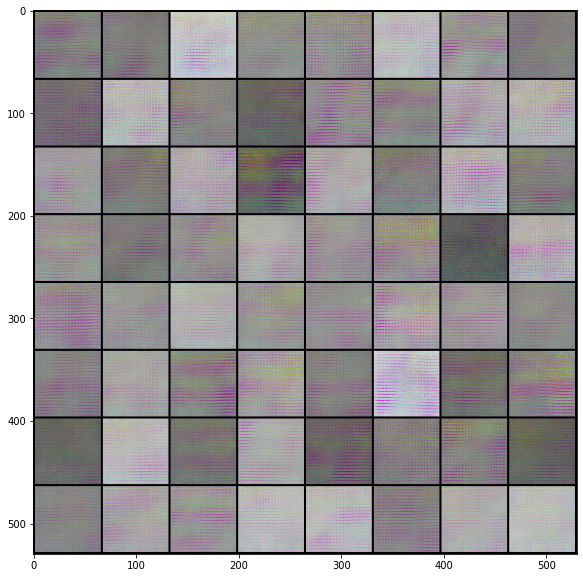

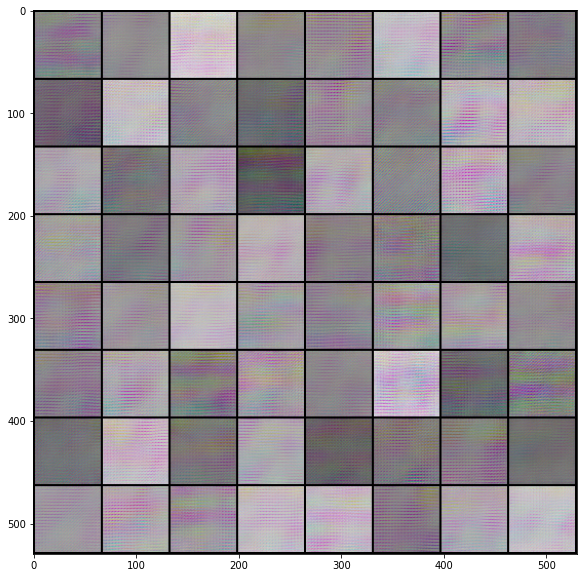

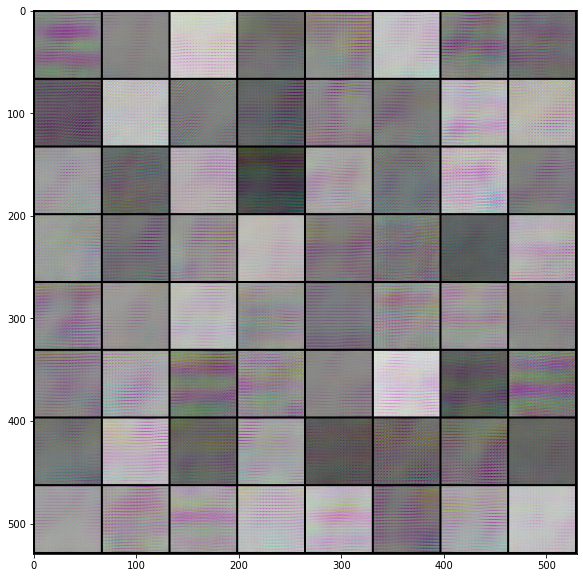

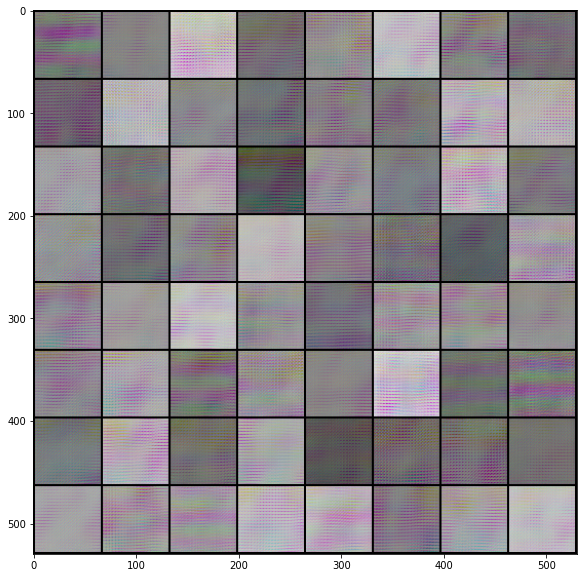

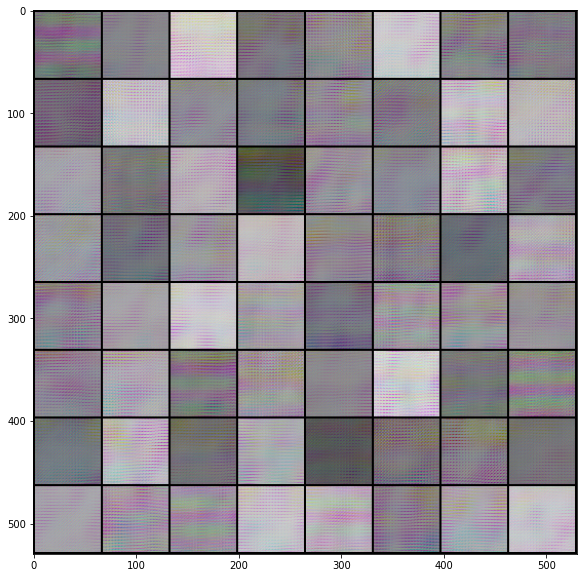

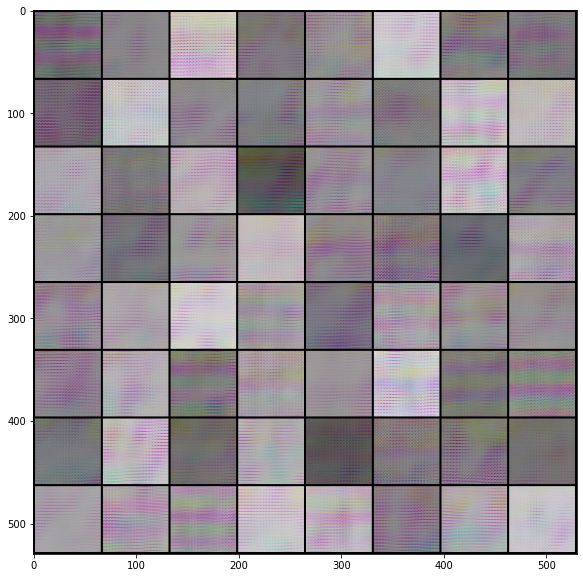

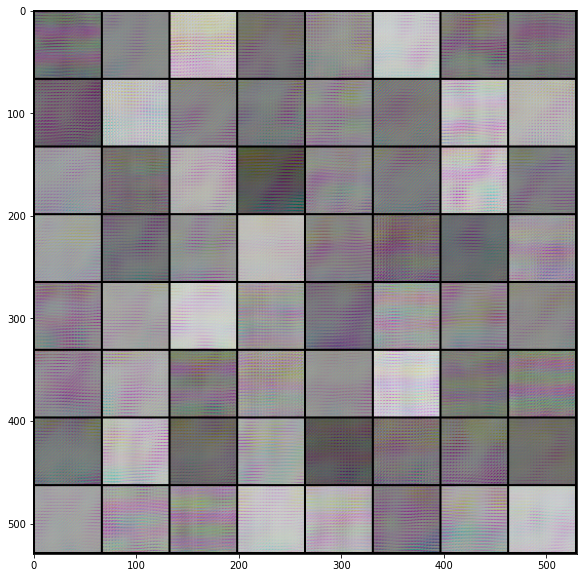

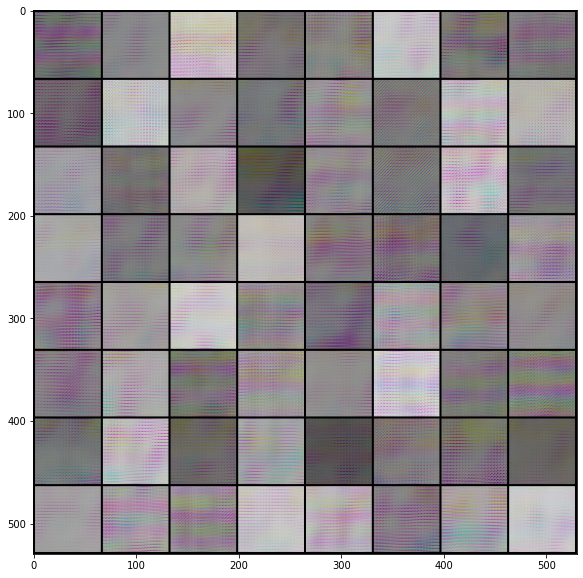

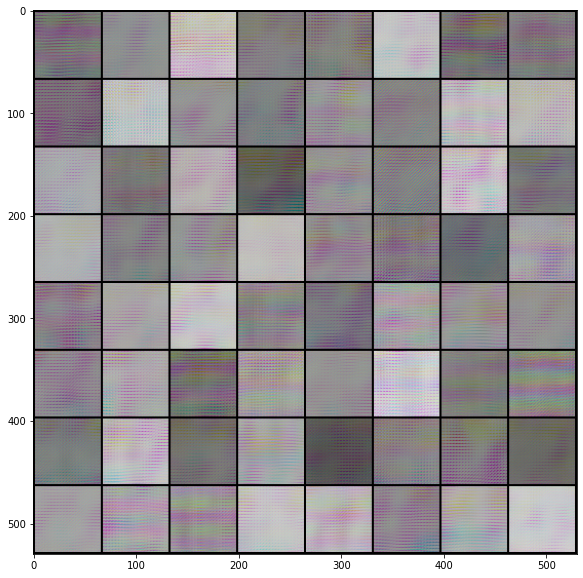

In [22]:
for i in range(5,epochs,10):
    pl.figure(figsize=(10,10))
    pl.imshow(np.transpose(images_from_noise[i],
                           (1,2,0))*.9)
pl.show()